In [1]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

2025-09-22 07:11:06.470 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: G:\Projects\Fusion-3D-CNN


Project root added to path: g:\Projects\Fusion-3D-CNN


Using STEP file: G:\Projects\Fusion-3D-CNN\data\processed\dataset_129\stp\Колодка приклада 4.prt.stp


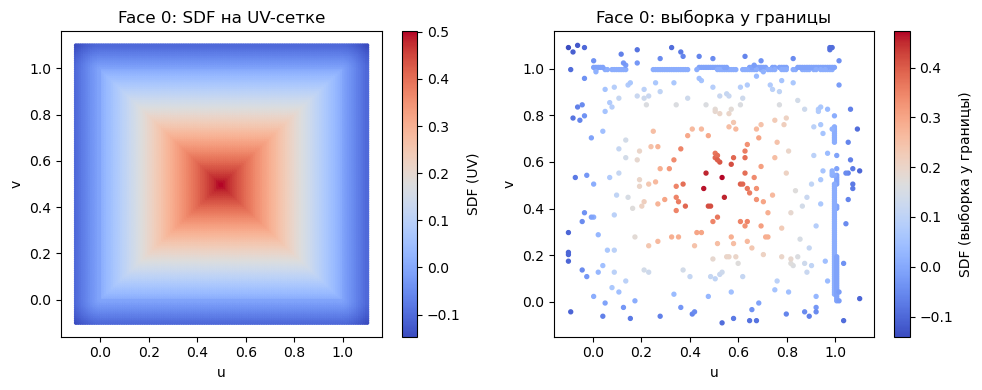

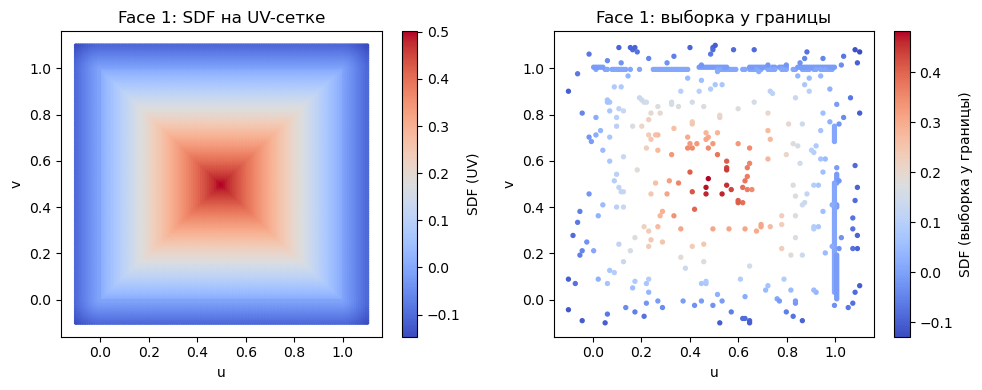

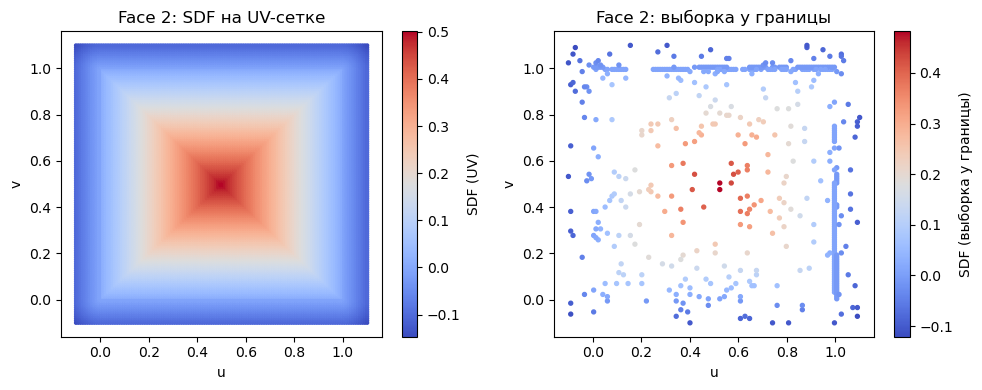

Граней: 85; всего SDF-точек на сетках: [ 0.02834646  0.02834646  0.02834646 ... -0.40287894 -0.42140034
 -0.44096744]; выборок у границы на грань: 500


In [2]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# OCC
from OCC.Core.STEPControl import STEPControl_Reader
from OCC.Core.IFSelect import IFSelect_RetDone
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_FACE, TopAbs_IN
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.BRepClass import BRepClass_FaceClassifier
from OCC.Core.gp import gp_Pnt2d

def ensure_uv_2d(x):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0:
        return np.zeros((0, 2), dtype=np.float32)
    if x.ndim == 2 and x.shape[1] == 2:
        return x
    if x.ndim == 1 and x.shape[0] == 2:
        return x.reshape(1, 2)
    return x.reshape(-1, 2)

def sample_uv_extended(resolution, extend=0.1):
    u = np.linspace(-extend, 1 + extend, resolution)
    v = np.linspace(-extend, 1 + extend, resolution)
    uu, vv = np.meshgrid(u, v, indexing='ij')
    return np.stack([uu.flatten(), vv.flatten()], axis=-1)

def compute_sdf(inside_points, outside_points):
    inside = ensure_uv_2d(inside_points)
    outside = ensure_uv_2d(outside_points)

    if inside.shape[0] == 0 and outside.shape[0] == 0:
        return np.zeros((0, 2), dtype=np.float32), np.zeros((0,), dtype=np.float32)
    if inside.shape[0] == 0:
        return outside, -np.zeros((outside.shape[0],), dtype=np.float32)
    if outside.shape[0] == 0:
        return inside, np.zeros((inside.shape[0],), dtype=np.float32)

    inside_tree = KDTree(outside)
    outside_tree = KDTree(inside)
    d_inside, _ = inside_tree.query(inside)
    d_outside, _ = outside_tree.query(outside)

    sdf_inside = d_inside.astype(np.float32)
    sdf_outside = -d_outside.astype(np.float32)
    sdf_points = np.concatenate([inside, outside], axis=0)
    sdf_values = np.concatenate([sdf_inside, sdf_outside], axis=0)
    return ensure_uv_2d(sdf_points), sdf_values.astype(np.float32)

def bias_sample_sdf(sdf_points, sdf_values, n_samples, boundary_ratio=0.4):
    pts = ensure_uv_2d(sdf_points)
    vals = np.asarray(sdf_values, dtype=np.float32).reshape(-1)
    if pts.shape[0] == 0:
        return pts, vals
    idx = np.argsort(np.abs(vals))
    nb = int(n_samples * boundary_ratio)
    nb = max(0, min(nb, idx.size))
    i_boundary = idx[:nb]
    i_pool = idx[nb:]
    if i_pool.size:
        i_pool = np.random.permutation(i_pool)
    need_rand = max(0, n_samples - nb)
    i_sel = np.concatenate([i_boundary, i_pool[:min(need_rand, i_pool.size)]], axis=0)
    i_sel = i_sel.astype(int)
    return pts[i_sel], vals[i_sel]

# ---------- привязка к реальной грани ----------
def query_cad_kernel_face(face, uv_samples):
    """
    Делим UV на inside/outside относительно ТРИМОВ грани через CAD-ядро.
    """
    uv = ensure_uv_2d(uv_samples)
    surf = BRepAdaptor_Surface(face)
    u0, u1 = surf.FirstUParameter(), surf.LastUParameter()
    v0, v1 = surf.FirstVParameter(), surf.LastVParameter()
    clf = BRepClass_FaceClassifier()

    mask = []
    for uv_ in uv:
        uu = float(u0 + float(uv_[0]) * (u1 - u0))
        vv = float(v0 + float(uv_[1]) * (v1 - v0))
        p2d = gp_Pnt2d(uu, vv)
        clf.Perform(face, p2d, 1e-9)
        mask.append(clf.State() == TopAbs_IN)

    mask = np.array(mask, dtype=bool)
    inside  = uv[mask]
    outside = uv[~mask]
    return ensure_uv_2d(inside), ensure_uv_2d(outside)

def compute_xyz_from_uv_face(face, uv_coords):
    uv = ensure_uv_2d(uv_coords)
    if uv.shape[0] == 0:
        return np.zeros((0, 3), dtype=np.float32)
    surf = BRepAdaptor_Surface(face)
    u0, u1 = surf.FirstUParameter(), surf.LastUParameter()
    v0, v1 = surf.FirstVParameter(), surf.LastVParameter()
    uu = u0 + uv[:, 0] * (u1 - u0)
    vv = v0 + uv[:, 1] * (v1 - v0)
    out = np.zeros((uv.shape[0], 3), dtype=np.float32)
    for i in range(uv.shape[0]):
        p = surf.Value(float(uu[i]), float(vv[i]))
        out[i, 0] = p.X(); out[i, 1] = p.Y(); out[i, 2] = p.Z()
    return out

# ---------- загрузка STEP и обход граней ----------
def load_shape(step_path: str):
    r = STEPControl_Reader()
    assert r.ReadFile(step_path) == IFSelect_RetDone, "STEP read failed"
    r.TransferRoots()
    return r.OneShape()
from OCC.Extend import TopologyUtils
def iter_faces(shape):
    top_exp = TopologyUtils.TopologyExplorer(shape, ignore_orientation=True)
    for face in top_exp.faces():
        yield face

# ---------- быстрая проверка на 1-й грани ----------
def quick_sdf_check_all(step_path: str, res=128, extend=0.1, n_samples=500, show_first_k=2):
    shape = load_shape(step_path)
    faces = list(iter_faces(shape))
    assert len(faces) > 0, "Нет граней в модели"

    all_sdf_uv   = []   # список [ [n_i,2], ... ]
    all_sdf_vals = []   # список [ [n_i],   ... ]
    all_samp_uv  = []   # список [ [n_samples,2], ... ]
    all_samp_sdf = []   # список [ [n_samples],   ... ]
    all_targ_xyz = []   # список [ [n_samples,3], ... ]

    for i, face in enumerate(faces):
        if i >= 3:
            break
        uv = sample_uv_extended(resolution=res, extend=extend)            # [M,2] torch
        inside, outside = query_cad_kernel_face(face, uv)                 # [*,2]
        sdf_pts, sdf_vals = compute_sdf(inside, outside)                  # [M',2],[M']
        samp_uv, samp_sdf = bias_sample_sdf(sdf_pts, sdf_vals,
                                            n_samples=n_samples, boundary_ratio=0.4)
        targ_xyz = compute_xyz_from_uv_face(face, samp_uv)                # [n_samples,3]

        all_sdf_uv.append(sdf_pts)
        all_sdf_vals.append(sdf_vals)
        all_samp_uv.append(samp_uv)
        all_samp_sdf.append(samp_sdf)
        all_targ_xyz.append(targ_xyz)

        # необязательная визуализация для первых k граней
        # if i < show_first_k:
        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        sc = ax[0].scatter(sdf_pts[:,0], sdf_pts[:,1],
                            c=sdf_vals, s=4, cmap="coolwarm")
        fig.colorbar(sc, ax=ax[0], label="SDF (UV)")
        ax[0].set_title(f"Face {i}: SDF на UV-сетке")
        ax[0].set_xlabel("u"); ax[0].set_ylabel("v")

        sc2 = ax[1].scatter(samp_uv[:,0], samp_uv[:,1],
                                c=samp_sdf, s=8, cmap="coolwarm")
        fig.colorbar(sc2, ax=ax[1], label="SDF (выборка у границы)")
        ax[1].set_title(f"Face {i}: выборка у границы")
        ax[1].set_xlabel("u"); ax[1].set_ylabel("v")
        plt.tight_layout(); plt.show()

    # сводка
    total_points = sum(v for v in all_sdf_vals)
    print(f"Граней: {len(faces)}; всего SDF-точек на сетках: {total_points}; "
          f"выборок у границы на грань: {n_samples}")

    return {
        "faces_count": len(faces),
        "sdf_grid_uv_list": all_sdf_uv,        # список torch тензоров [n_i,2]
        "sdf_grid_vals_list": all_sdf_vals,    # список torch тензоров [n_i]
        "sampled_uv_list": all_samp_uv,        # список torch тензоров [n_samples,2]
        "sampled_sdf_list": all_samp_sdf,      # список torch тензоров [n_samples]
        "target_xyz_list": all_targ_xyz        # список torch тензоров [n_samples,3]
    }

STEPS_DIR = PROCESSED_DATA_DIR / "dataset_129" / "stp"

step_files = stems = {p for p in STEPS_DIR.glob("*.stp")}

stp = list(step_files)[15]
print(f"Using STEP file: {stp}")
out = quick_sdf_check_all(str(stp), res=128, extend=0.1, n_samples=500)



In [22]:
from src.modeling.SSL_BrepNet import extract_features

FEATURES_LIST_PATH = EXTERNAL_DATA_DIR / "feature_lists" / "all.json"
STEPS_DIR = PROCESSED_DATA_DIR / "dataset_129" / "stp"
extract_features.run(
    step_path_dir=STEPS_DIR,
    feature_list_path=FEATURES_LIST_PATH,
    num_workers=0,
    force_regeneration=True
)

2025-09-21 13:28:30.564 | INFO     | src.modeling.SSL_BrepNet.extract_features:extract_brepnet_data_from_step:43 - Начало обработки: force_regeneration=True, num_workers=0


100%|██████████| 129/129 [05:12<00:00,  2.42s/it]

2025-09-21 13:33:43.242 | SUCCESS  | src.modeling.SSL_BrepNet.extract_features:extract_brepnet_data_from_step:60 - Обработка завершена.


In [31]:
from src.modeling.SSL_BrepNet import build_dataset_file
BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"
STATS_BREPNET = PROCESSED_DATA_DIR / "dataset_129" / "dataset_brepnet_stats.json"
os.makedirs(BREPNET_NPZ_DIR, exist_ok=True)
build_dataset_file.run(
    brepnet_dir=BREPNET_NPZ_DIR,
    output_file=STATS_BREPNET,
    validation_split=0.1,
    test_split=0.1,
    random_seed=42,
)

2025-09-21 13:45:13.471 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:88 - Найдено 129 общих моделей.
2025-09-21 13:45:13.471 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:97 - Разделение: 104 train, 12 validation, 13 test.
2025-09-21 13:45:13.471 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:find_brepnet_standardization:51 - Вычисление статистик стандартизации для B-repNet...


100%|██████████| 104/104 [00:00<00:00, 307.84it/s]

2025-09-21 13:45:13.810 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:114 - 
Файл набора данных успешно создан: G:\Projects\Fusion-3D-CNN\data\processed\dataset_129\dataset_brepnet_stats.json


In [3]:
BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"
import numpy as np
npz_files = list(BREPNET_NPZ_DIR.glob("*.npz"))
print(f"Всего .npz файлов: {len(npz_files)}")

with np.load(npz_files[3]) as data:
    for k, v in data.items():
        print(f"{k}: {v.shape}, dtype={v.dtype}, min={v.min() if v.size>0 else 'N/A'}, max={v.max() if v.size>0 else 'N/A'}")

# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "all_sdf_with_normals"
# npz_files = list(BREPNET_NPZ_DIR.glob("*.npz"))
# print(f"Всего .npz файлов: {len(npz_files)}")

# with np.load(npz_files[0]) as data:
#     for k, v in data.items():
#         print(f"{k}: {v.shape}, dtype={v.dtype}, min={v.min() if v.size>0 else 'N/A'}, max={v.max() if v.size>0 else 'N/A'}")

# os.makedirs(BREPNET_NPZ_DIR, exist_ok=True)

# for npz_path in npz_files:
#     with np.load(npz_path) as data:
#         uv_faces = data['uv_faces']          # [n,2]
#         sdf_faces = data['sdf_faces']    # [n]
#     np.savez_compressed(BREPNET_NPZ_DIR / npz_path.name, uv_faces=uv_faces, sdf_faces=sdf_faces)
#     print(f"Обработан файл {npz_path}, добавлены нормали.")

Всего .npz файлов: 129
face_features: (9, 7), dtype=float64, min=0.0, max=7.339927890980251
face_point_grids: (9, 7, 10, 10), dtype=float64, min=-1.0, max=1.0
edge_features: (16, 10), dtype=float64, min=0.0, max=4.1887900628499
coedge_point_grids: (31, 12, 10), dtype=float64, min=-1.0, max=1.0
coedge_features: (31, 1), dtype=float64, min=0.0, max=1.0
coedge_lcs: (31, 4, 4), dtype=float64, min=-1.0, max=1.0
coedge_scale_factors: (31,), dtype=float64, min=1.1111111487609353, max=2.000000068812871
coedge_reverse_flags: (31,), dtype=float64, min=0.0, max=1.0
next: (31,), dtype=uint32, min=0, max=30
mate: (31,), dtype=uint32, min=0, max=30
face: (31,), dtype=uint32, min=0, max=8
edge: (31,), dtype=uint32, min=0, max=15
vertex: (10, 3), dtype=float64, min=-0.9999999655935654, max=0.9999999666367527
edge_to_vertex: (2, 16), dtype=uint32, min=0, max=9
face_to_edge: (2, 25), dtype=uint32, min=0, max=15
face_to_face: (2, 8), dtype=uint32, min=0, max=8


In [5]:
from src.modeling.SSL_BrepNet.dataset import BrepNetDataset
STATS_BREPNET = PROCESSED_DATA_DIR / "dataset_129" / "dataset_brepnet_stats.json"
SDF_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "all_sdf_with_normals"
BREP_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"

train_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, SDF_NPZ_DIR, split="training_set")
val_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, SDF_NPZ_DIR, split="validation_set")
test_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, SDF_NPZ_DIR, split="test_set")

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
for k, v in train_dataset[0].items():
    print(f"{k}: {tuple(v.shape) if isinstance(v, torch.Tensor) else type(v)}")

Train samples: 104, Val samples: 12, Test samples: 13
name: <class 'str'>
vertices: (76, 3)
edges: (125, 10)
faces: (51, 7)
edge_to_vertex: (2, 125)
face_to_edge: (244, 2)
face_to_face: (2, 116)
sdf_uv: (51, 500, 2)
sdf_vals: (51, 500)


In [10]:
from src.modeling.SSL_BrepNet.model.encoder import CustomBRepEncoder
from src.modeling.SSL_BrepNet.model.decoder import ConditionalDecoder
import torch

encoder = CustomBRepEncoder(
    v_in_width=3,             
    e_in_width=10, 
    f_in_width=7, 
    out_width=64,
    num_layers=2,
    use_attention=True
)

emb = encoder(train_dataset[99])
   

for k, v in train_dataset[99].items():
    print(f"{k}: {tuple(v.shape) if isinstance(v, torch.Tensor) else type(v)}")
print("OK. encoder output shape:", tuple(emb.shape) if isinstance(emb, torch.Tensor) else type(emb))

decoder = ConditionalDecoder(latent_size=64, hidden_dims=[1024, 1024, 1024, 1024])

# uv_faces: (9, 500, 2), dtype=float32, min=-0.10000000149011612, max=1.100000023841858
# sdf_faces: (9, 500), dtype=float32, min=-0.39380156993865967, max=0.4913385510444641



pred_sdf = decoder(train_dataset[0]['sdf_uv'][0], emb[0])   # [n_faces, n_samples]

print("OK. decoder output shape:", tuple(pred_sdf.shape) if isinstance(pred_sdf, torch.Tensor) else type(pred_sdf))

name: <class 'str'>
vertices: (161, 3)
edges: (243, 10)
faces: (83, 7)
edge_to_vertex: (2, 243)
face_to_edge: (469, 2)
face_to_face: (2, 220)
sdf_uv: (83, 500, 2)
sdf_vals: (83, 500)
OK. encoder output shape: (83, 64)
OK. decoder output shape: (500, 4)


In [9]:
from torch.utils.data import DataLoader

from src.modeling.SSL_BrepNet.model.brep_autoencoder import BRepAutoEncoderModule

module = BRepAutoEncoderModule()

def collate_single(samples):
    assert len(samples) == 1, "Этот автоэнкодер работает с batch_size=1"
    return samples[0]

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  collate_fn=collate_single,
                          num_workers=0, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_single,
                          num_workers=0, pin_memory=torch.cuda.is_available())

b = train_dataset[0]
with torch.no_grad():
    z = module.encoder(b)
print("enc_out:", z.shape, "faces:", z.size(0), "finite:", bool(torch.isfinite(z).all()))
print("queue:", tuple(module.z_queue.shape), "finite:", bool(torch.isfinite(module.z_queue).all()))



enc_out: torch.Size([51, 64]) faces: 51 finite: True
queue: (64, 4096) finite: True


In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger(save_dir=REPORTS_DIR, name="ssl_autoencoder_logs")
trainer = Trainer(
    max_epochs=10, 
    logger=[csv_logger],
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    detect_anomaly=True, 
)
trainer.fit(module, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | encoder   | Cu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Kaktus\.conda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Kaktus\.conda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [118]:
import torch
import torch.nn.functional as F
import pandas as pd

@torch.no_grad()
def collect_embeddings(module, loader, device=None, noise_std: float = 0.01):
    """Собираем глобальные эмбеддинги (query, key) для каждого сэмпла вал-сета."""
    device = device or next(module.parameters()).device
    enc_q = module.encoder.eval()
    enc_k = module.encoder_m.eval()

    Zq, Zk = [], []
    for batch in loader:
        # query
        zq_faces = enc_q(batch)                          # [F, D]
        zq_faces = torch.nan_to_num(zq_faces)
        zq = F.normalize(zq_faces.mean(dim=0), dim=0)    # [D]

        # key (лёгкая аугментация на float-полях)
        batch_aug = {}
        for k, v in batch.items():
            if torch.is_tensor(v) and v.dtype.is_floating_point:
                batch_aug[k] = (v + noise_std * torch.randn_like(v)).to(device)
            else:
                batch_aug[k] = v
        zk_faces = enc_k(batch_aug)
        zk_faces = torch.nan_to_num(zk_faces)
        zk = F.normalize(zk_faces.mean(dim=0), dim=0)

        Zq.append(zq)
        Zk.append(zk)

    Zq = F.normalize(torch.stack(Zq), dim=-1)            # [N, D]
    Zk = F.normalize(torch.stack(Zk), dim=-1)            # [N, D]
    return Zq, Zk

@torch.no_grad()
def recall_at_ks(Zq: torch.Tensor, Zk: torch.Tensor, ks=(1,5,10)):
    """Recall@K: входит ли правильный ключ (тот же индекс) в топ-K по косинусу."""
    sim = Zq @ Zk.T                                      # [N, N]
    ranks = sim.argsort(dim=1, descending=True)
    diag = torch.arange(sim.size(0), device=sim.device)
    out = {}
    for k in ks:
        out[k] = (ranks[:, :k] == diag[:, None]).any(dim=1).float().mean().item()
    # доп. сводка для мониторинга разделимости
    pos = sim.diag()
    neg = (sim.sum(dim=1) - pos) / (sim.size(1) - 1)
    summary = {
        "pos_mean": pos.mean().item(),
        "pos_std":  pos.std(unbiased=False).item(),
        "neg_mean": neg.mean().item(),
        "neg_std":  neg.std(unbiased=False).item(),
        "margin":   (pos - neg).mean().item(),
    }
    return out, summary

def cos_to_percent(sim: torch.Tensor) -> torch.Tensor:
    return torch.clamp((sim + 1.0) * 50.0, 0.0, 100.0)

@torch.no_grad()
def collect_embeddings_with_names(module, loader, use_momentum_as_index: bool = True, noise_std: float = 0.01):
    """
    Возвращает:
      Zq: [N, D] — эмбеддинги запросов (encoder)
      Zidx: [N, D] — эмбеддинги индекса (encoder_m если use_momentum_as_index=True, иначе encoder)
      names: список имён/идентификаторов длины N
    """
    enc_q = module.encoder.eval()
    enc_i = module.encoder_m.eval() if use_momentum_as_index else module.encoder.eval()

    Zq, Zidx, names = [], [], []

    for b in loader:  # batch_size=1 и collate_single -> b — это dict одного сэмпла
        # имя/идентификатор
        nm = b.get('name', None)
        names.append(nm if isinstance(nm, str) else str(nm))

        # query
        zq_faces = enc_q(b)
        zq_faces = torch.nan_to_num(zq_faces)
        zq = F.normalize(zq_faces.mean(dim=0), dim=0)  # [D]

        # index (с лёгкой аугментацией на float-полях, как в валидации MoCo)
        if use_momentum_as_index:
            b_aug = {}
            for k, v in b.items():
                if torch.is_tensor(v) and v.dtype.is_floating_point:
                    b_aug[k] = v + noise_std * torch.randn_like(v)
                else:
                    b_aug[k] = v
            zi_faces = enc_i(b_aug)
        else:
            zi_faces = enc_i(b)
        zi_faces = torch.nan_to_num(zi_faces)
        zi = F.normalize(zi_faces.mean(dim=0), dim=0)

        Zq.append(zq)
        Zidx.append(zi)

    Zq   = F.normalize(torch.stack(Zq),   dim=-1)  # [N, D]
    Zidx = F.normalize(torch.stack(Zidx), dim=-1)  # [N, D]
    return Zq, Zidx, names

@torch.no_grad()
def topk_table_for_idx(Zq: torch.Tensor, Zidx: torch.Tensor, names, idx: int, k: int = 10, exclude_self: bool = True) -> pd.DataFrame:
    """
    Для запроса с индексом idx показать Top-k по индексу Zidx.
    """
    sim = (Zq[idx] @ Zidx.T)  # [N]
    # исключаем самого себя, если это один и тот же набор
    if exclude_self:
        sim[idx] = -1.0

    vals, inds = torch.topk(sim, k=min(k, sim.numel()))
    perc = cos_to_percent(vals)

    rows = []
    for rank, (j, s, p) in enumerate(zip(inds.tolist(), vals.tolist(), perc.tolist()), start=1):
        rows.append({
            "rank": rank,
            "index": j,
            "name": names[j] if j < len(names) else f"#{j}",
            "cosine": round(float(s), 4),
            "similarity_%": round(float(p), 1),
        })
    return pd.DataFrame(rows)

In [132]:
module.eval()
Zq, Zk = collect_embeddings(module, val_loader, device=module.device, noise_std=0.01)
rec, summ = recall_at_ks(Zq, Zk, ks=(1,5,10))
print(f"VAL Recall: @1={rec[1]:.3f} @5={rec[5]:.3f} @10={rec[10]:.3f}")
print(f"VAL Summary: pos_mean={summ['pos_mean']:.3f} neg_mean={summ['neg_mean']:.3f} margin={summ['margin']:.3f}")

VAL Recall: @1=1.000 @5=1.000 @10=1.000
VAL Summary: pos_mean=0.952 neg_mean=0.762 margin=0.190


In [139]:
module.eval()
Zq, Zidx, names = collect_embeddings_with_names(module, train_loader, use_momentum_as_index=True, noise_std=0.01)

# покажем Top-10 для запроса с индексом 0
df_top10 = topk_table_for_idx(Zq, Zidx, names, idx=27, k=20, exclude_self=False)
print(df_top10.to_string(index=False))

 rank  index                     name  cosine  similarity_%
    1     90  42. Silencer Fix-02.prt  0.9678          98.4
    2     27  42. Silencer Fix-01.prt  0.9677          98.4
    3     30     42. Silencer Fix.prt  0.9676          98.4
    4     80             Затвор 4.prt  0.8506          92.5
    5     69             Затвор 8.prt  0.8432          92.2
    6      4             Затвор 6.prt  0.8431          92.2
    7     45             Затвор 7.prt  0.8379          91.9
    8     11     43. Extractor-03.prt  0.7743          88.7
    9     50     43. Extractor-01.prt  0.7689          88.4
   10      9        43. Extractor.prt  0.7587          87.9
   11     81             Затвор 1.prt  0.6443          82.2
   12     31            Защелка 5.prt  0.5530          77.7
   13     35            Защелка 4.prt  0.5174          75.9
   14     38            Защелка 8.prt  0.4746          73.7
   15     95            Защелка 9.prt  0.4622          73.1
   16     36            Защелка 7.prt  0